<a href="https://www.kaggle.com/code/adamdandi/fraud-analysis-based-on-transaction-timing?scriptVersionId=218418994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fraud Analysis with Transaction Time

## **Introduction**

Transaction data is a critical element in maintaining operational integrity and customer trust in any system. This document is created to analyze potential anomalies in transaction times within Barberking's operational services. These anomalies could indicate fraud or process discrepancies that require further investigation.

This analysis focuses on the transaction times performed by each barber, aiming to identify suspicious patterns through the calculation of the average transaction time delay. This effort aligns with the organization's goal to improve operational efficiency, fairness in commission distribution, and early detection of potential deviations.

## **Objectives**

1. **Detect Anomalies**: Identify barbers with the highest average transaction time delays to detect possible fraud or non-compliant practices.
2. **Determine Transaction Patterns**: Analyze normal transaction patterns compared to outliers to provide insights into potential operational issues.
3. **Provide Recommendations**: Generate data-driven recommendations to enhance trust in the payment system and improve operational efficiency.

## **Scope**

This analysis includes:
- Transaction data from all Barberking outlets within the specified period.
- Key variables: **OrderNo**, **OrderDate**, **OrderTime**, and **ServeBy**.
- Focus on transaction time patterns, including average and distribution of time delays between transactions.
- Assumptions that each order number (**OrderNo**) represents a unique transaction.

Limitations:
- Excludes transactions outside the given period.
- Potential data errors, such as inconsistent time recordings, cannot be fully eliminated.

## **Methodology/Approach**

1. **Data Processing**: Grouping data by barber (**ServeBy**) and order number (**OrderNo**) to calculate the time delay between transactions.
2. **Statistical Analysis**: Calculating daily average transaction delays and using statistical methods to identify outliers.
3. **Comparison**: Comparing barbers to detect individuals with suspicious transaction patterns.
4. **Reporting Results**: Presenting findings through visualizations and summaries that aid in decision-making.

## **Expected Outcomes**

1. A list of barbers with the highest average transaction time delays.
2. Identification of specific days or periods with suspicious transaction patterns.
3. Actionable recommendations for further investigation and fraud prevention policies.
4. Contribution to improving system efficiency and transparency in operations.

In [1]:
import pandas as pd
from pandasql import sqldf

#load dataset
data = pd.read_csv("/kaggle/input/salesbk/SALESBK.csv")
#define lambda to run sql query
sql = lambda q: sqldf(q, globals())

In [2]:
#query 1 grouping data by barberman, date, and time of transaction
query1= """
SELECT 
    ServeBy, 
    OrderNo, 
    MIN(OrderDate || ' ' || OrderTime) AS TransactionTime,
    OrderDate
FROM data
GROUP BY ServeBy, OrderNo, OrderDate
ORDER BY ServeBy, OrderDate, TransactionTime;
"""
#run query1
data_group=sql(query1)
#show result
print('grouping data by barberman, date, and time of transaction')
print(data_group)

grouping data by barberman, date, and time of transaction
                    ServeBy              OrderNo      TransactionTime  \
0        Ahmad Arif Setiono  57A5240801 00005435  2024-08-01 19:27:43   
1        Ahmad Arif Setiono  57A5240801 00005438  2024-08-01 20:16:28   
2        Ahmad Arif Setiono  57A5240801 00005439  2024-08-01 20:20:34   
3        Ahmad Arif Setiono  57A5240815 00005791  2024-08-15 15:23:32   
4        Ahmad Arif Setiono  57A5240815 00005798  2024-08-15 19:27:24   
...                     ...                  ...                  ...   
4181  Zainal Habib Purwanto  BB24240825 00005755  2024-08-25 16:18:03   
4182  Zainal Habib Purwanto  BB24240825 00005759  2024-08-25 18:49:43   
4183  Zainal Habib Purwanto  BB24240825 00005761  2024-08-25 19:58:42   
4184  Zainal Habib Purwanto  BB24240825 00005763  2024-08-25 21:00:00   
4185  Zainal Habib Purwanto  BB24240825 00005764  2024-08-25 21:01:49   

       OrderDate  
0     2024-08-01  
1     2024-08-01  
2     20

In [3]:
#query2 Using LAG to calculate the time lag between transactions
query2="""
SELECT 
    ServeBy, 
    OrderDate,
    TransactionTime,
    LAG(TransactionTime) OVER (PARTITION BY ServeBy, OrderDate ORDER BY TransactionTime) AS PreviousTransaction,
    (strftime('%s', TransactionTime) - strftime('%s', LAG(TransactionTime) OVER (PARTITION BY ServeBy, OrderDate ORDER BY TransactionTime))) / 60.0 AS TimeDifference
FROM data_group;
"""
#run query2
time_differences=sql(query2)
#show result
print('the time lag between transactions')
print(time_differences)

the time lag between transactions
                    ServeBy   OrderDate      TransactionTime  \
0        Ahmad Arif Setiono  2024-08-01  2024-08-01 19:27:43   
1        Ahmad Arif Setiono  2024-08-01  2024-08-01 20:16:28   
2        Ahmad Arif Setiono  2024-08-01  2024-08-01 20:20:34   
3        Ahmad Arif Setiono  2024-08-15  2024-08-15 15:23:32   
4        Ahmad Arif Setiono  2024-08-15  2024-08-15 19:27:24   
...                     ...         ...                  ...   
4181  Zainal Habib Purwanto  2024-08-25  2024-08-25 16:18:03   
4182  Zainal Habib Purwanto  2024-08-25  2024-08-25 18:49:43   
4183  Zainal Habib Purwanto  2024-08-25  2024-08-25 19:58:42   
4184  Zainal Habib Purwanto  2024-08-25  2024-08-25 21:00:00   
4185  Zainal Habib Purwanto  2024-08-25  2024-08-25 21:01:49   

      PreviousTransaction  TimeDifference  
0                    None             NaN  
1     2024-08-01 19:27:43       48.750000  
2     2024-08-01 20:16:28        4.100000  
3                    

In [4]:
import pandas as pd

# Calculate the average time lag per barberman per day
average_time_gap = (
    time_differences.groupby(['ServeBy', 'OrderDate'])['TimeDifference']
    .mean()
    .reset_index()
    .rename(columns={'TimeDifference': 'AverageTimeGap'})
)

# Identify the barberman with the highest average time lag
top_barberman = (
    average_time_gap.groupby('ServeBy')['AverageTimeGap']
    .mean()
    .reset_index()
    .sort_values(by='AverageTimeGap', ascending=False)
)

# Display descriptive statistics
descriptive_stats = average_time_gap['AverageTimeGap'].describe()

print("Descriptive Statistics for Average Time Gap:")
print(descriptive_stats)

# Show results in a scrollable table
def table(df, height=400):
    display(df.style.set_table_attributes(f'style="display:inline-block;overflow:auto;height:{height}px;width:auto;"').set_table_styles([{
        'selector': '',
        'props': [('border-collapse', 'collapse'),
                  ('margin', '0px')]}]))

# Display the table
table(top_barberman)
# Save the results to CSV files
top_barberman.to_csv('top_barberman_by_average_time_gap.csv', index=False)

Descriptive Statistics for Average Time Gap:
count    623.000000
mean      76.036916
std       34.395462
min       10.883333
25%       56.220370
50%       67.825000
75%       87.238333
max      387.116667
Name: AverageTimeGap, dtype: float64


,ServeBy,AverageTimeGap
0,Ahmad Arif Setiono,108.591667
9,Barberman David,108.535294
8,Barberman Abdul,96.750000
24,Muhammad Aliev Mustanir,88.698552
15,Dimas Ari Susanto,88.416046
20,Handri Prasetyo,85.779392
6,BARBERMAN MA DWI SANTOSO,84.530196
32,Zainal Habib Purwanto,84.395894
25,Muhammad Hendra Purnawan,83.363510
16,Dwi Santoso,82.377201


/tmp/ipykernel_17/1461317031.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', num_colors)  # Using 'tab20' colormap for up to 20 distinct colors


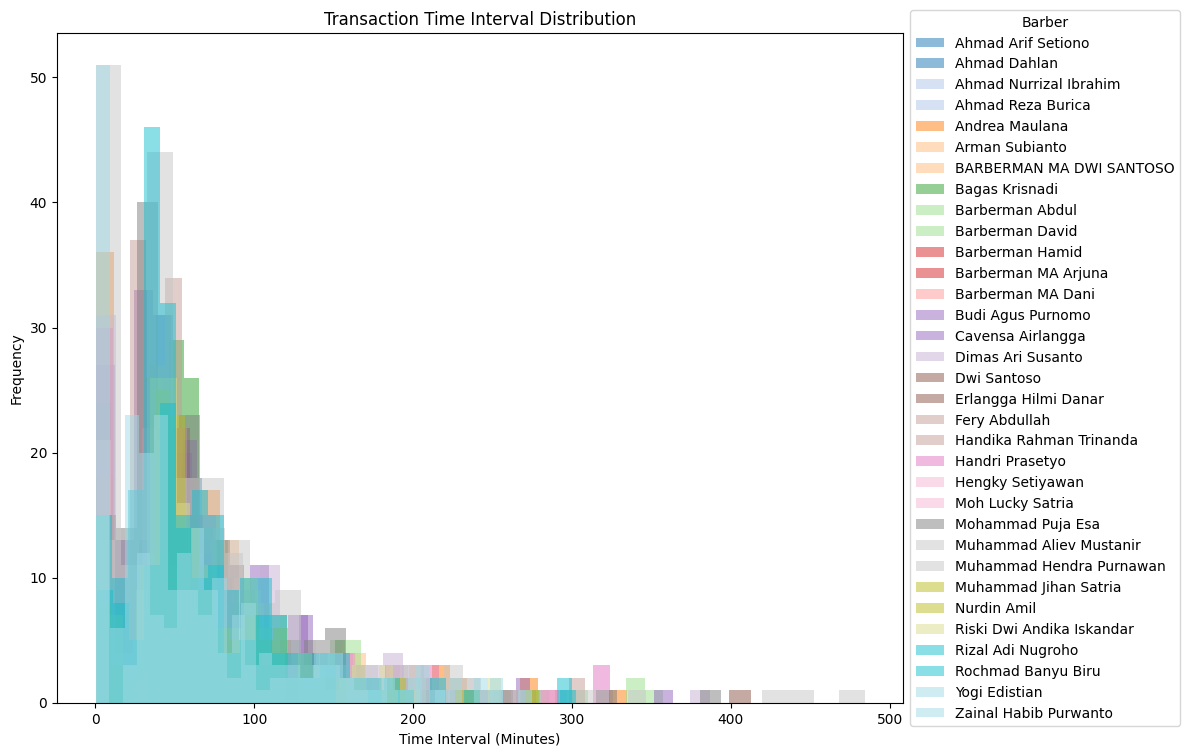

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generate a colormap
num_colors = len(time_differences['ServeBy'].unique())
colors = cm.get_cmap('tab20', num_colors)  # Using 'tab20' colormap for up to 20 distinct colors

# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust size as needed

# Histogram per barberman
for idx, barber in enumerate(time_differences['ServeBy'].unique()):
    data = time_differences[time_differences['ServeBy'] == barber]['TimeDifference'].dropna()
    plt.hist(data, bins=30, alpha=0.5, label=barber, color=colors(idx / num_colors))

plt.xlabel('Time Interval (Minutes)')
plt.ylabel('Frequency')
plt.title('Transaction Time Interval Distribution')

# Move legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Barber')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Interpretation and Recommendations

### Interpretation

1. **Top Performers:**
   - Barbers with the highest average time gaps, such as Ahmad Arif Setiono (108.59 minutes) and Barberman David (108.54 minutes), may:
   - Provide more detailed or premium services, requiring additional time per client.
   - Face delays due to inefficiencies or other external factors.

2. **Moderate Performers:**
   - Barbers with average time gaps around the mean (e.g., Barberman Abdul at 96.75 minutes) represent a balance between quality and efficiency.

3. **Efficient Performers:**
   - Barbers like Muhammad Aliev Mustanir (88.70 minutes) and Dimas Ari Susanto (88.42 minutes) demonstrate quicker service, which could result from:
   - Streamlined processes.
     - Handling simpler or faster tasks.

4. **Shortest Time Gaps:**
   - Barbers at BK01 - ATMI, including Ahmad Reza Burica, MA Dani, and MA Arjuna, recorded 0-minute gaps but only had one transaction each. This may indicate insufficient data for these barbers to draw meaningful conclusions about their efficiency.

5. **Overall Trend:**
   - The range of average time gaps highlights a diversity in service styles. Extreme outliers may indicate opportunities for process improvements or specialized training.

### Recommendations

#### For Barbers with Longer Time Gaps:
1. **Process Streamlining:**
   - Offer training to enhance efficiency in areas like preparation, execution, and cleanup.

2. **Root Cause Analysis:**
   - Investigate causes for longer times, such as service complexity, and address recurring inefficiencies.

3. **Leverage Expertise:**
   - Position these barbers for premium services where additional time aligns with customer expectations.

#### For Efficient Barbers:
1. **Reward Performance:**
   - Recognize and incentivize barbers like Muhammad Aliev Mustanir and Dimas Ari Susanto for their efficiency to sustain motivation.

2. **Knowledge Sharing:**
   - Encourage them to mentor peers by sharing tips for maintaining quality while minimizing time gaps.

#### Operational Improvements:
1. **Balanced Scheduling:**
   - Adjust appointment durations based on historical performance metrics to better match each barber’s pace.

2. **Customer Distribution:**
   - Evenly distribute workload to prevent overburdening efficient barbers and ensure all barbers are fully utilized.

3. **Performance Reviews:**
   - Continuously monitor average time gaps and provide actionable feedback to maintain balance between speed and quality.

#### Customer Experience:
1. **Transparency in Service Times:**
   - Clearly communicate estimated service times to manage expectations and improve satisfaction.

2. **Customized Pricing:**
   - Introduce pricing tiers that reflect service duration and expertise, ensuring perceived value aligns with customer experiences.